# Test ADVI

It works!

https://github.com/martiningram/jax_advi

We modify the likelihood to a pseudolikelihood thats include the log det Jacobian of the transformation of prior $N(0,1)$.

With better posterior covariances (like a MAP approximation): linear response variational Bayes. Operates on the result of a vanilla ADVI run.

https://martiningram.github.io/vi-with-good-covariances/

## Elliptical slice sampling

Another technique which could make use of our $N(0,1)$ priors.
Elliptical slice sampling is a MCMC method for problems with Gaussian priors. [Murray2010]
For VI we use $N(0,1)$ priors which are then transformed and for nested sampling we use $U(0,1)$ priors which are then transformed.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels
from dgf import constants
from dgf import bijectors
from dgf.prior import lf
from dgf.prior import source

import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

import jax_advi

In [2]:
# Sample from the source and noise priors and fit a prior in the `z` domain
BOUNDS = constants.SOURCE_BOUNDS.copy()
BOUNDS['noise_power'] = [constants.NOISE_FLOOR_POWER, 1.]
PARAMS = ['var', 'r', 'T', 'Oq', 'noise_power']
NUMPARAMS = len(PARAMS) # == 5

source_params_ppf = source._get_source_params_ppf(
    constants.SOURCE_BOUNDS, constants.SOURCE_MEDIAN, source.RHO
)

# No correlations at all b/c synthetic prior
samples = np.hstack([
    source_params_ppf(rand(int(1e4), NUMPARAMS-1)),
    source.noise_power_ppf(rand(int(1e4), 1), constants.NOISE_FLOOR_DB)
])

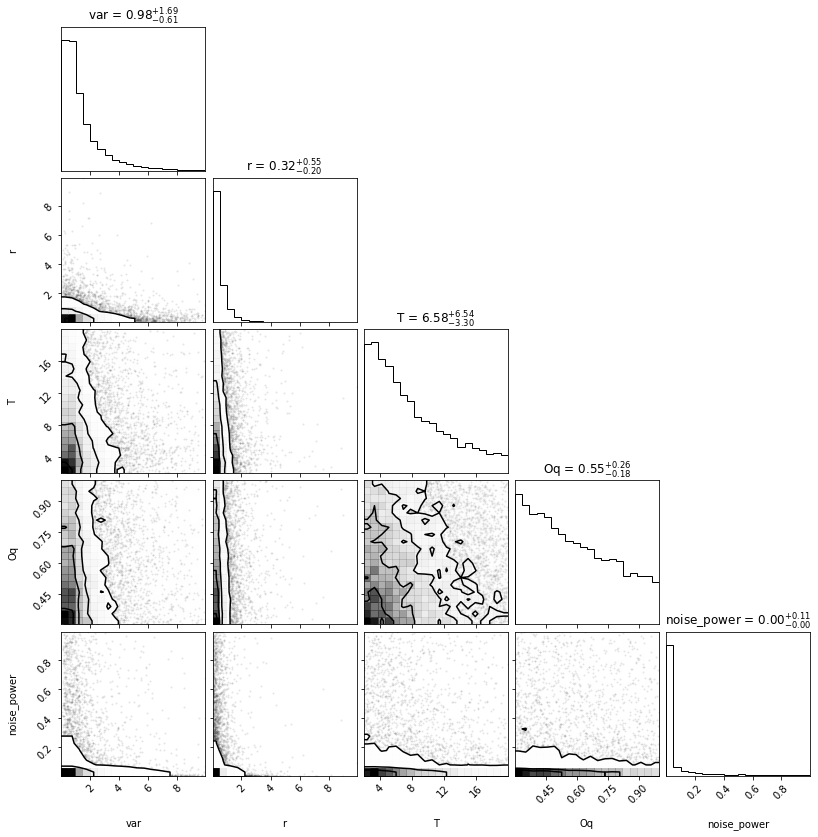

In [3]:
import corner

fig = corner.corner(
    samples,
    labels=PARAMS,
    show_titles=True,
    smooth=.2
)

In [4]:
z = np.log(samples)
z_mean = np.mean(z, axis=0)
z_cov = np.cov(z.T)
z_sigma = np.sqrt(np.diag(z_cov))
z_corr = np.diag(1/z_sigma) @ z_cov @ np.diag(1/z_sigma)
L_z_corr = np.linalg.cholesky(z_corr)

z_bounds = np.log(np.array([
    BOUNDS[k] for k in PARAMS
]))

In [5]:
import dynesty
import scipy.stats

static_bijector = tfb.Chain([
    tfb.Exp(), tfb.SoftClip(
        z_bounds[:,0], z_bounds[:,1], z_sigma
    )
])

def getprior(rescale):
    L = np.diag(rescale*z_sigma) @ L_z_corr
    prior = tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=z_mean,
            scale_tril=L
        ),
        bijector=static_bijector
    )
    return prior

def loglike(rescale, data=samples):
    prior = getprior(rescale)
    lp = np.sum(prior.log_prob(data))
    return -np.inf if np.isnan(lp) else float(lp)

def ptform(
    u,
    rescale_prior=scipy.stats.expon(scale=1.)
):
    return rescale_prior.ppf(u)

ndim = NUMPARAMS
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=ndim*5)
sampler.run_nested()
results = sampler.results

727it [11:43,  1.03it/s, +25 | bound: 294 | nc: 1 | ncall: 14029 | eff(%):  5.370 | loglstar:   -inf < 2977.448 <    inf | logz: 2952.356 +/-  0.950 | dlogz:  0.001 >  0.034]


In [6]:
# Rescale (stretch) factors
results.samples[-1,:]

array([1.23297956, 1.07295121, 1.86789406, 2.02456959, 2.0611829 ])

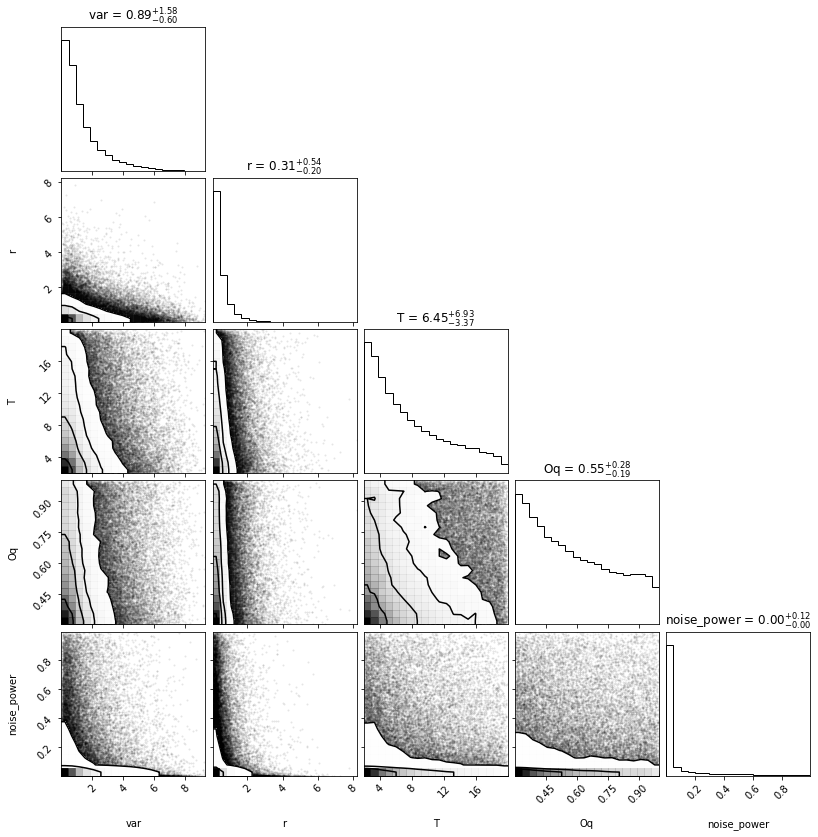

In [10]:
# Very good model of the data without problems at the edges
priorml = getprior(results.samples[-1,:])

fig = corner.corner(
    np.array(priorml.sample(100000,seed=jax.random.PRNGKey(1387))),
    labels=PARAMS,
    show_titles=True,
    smooth=.2
)

In [11]:
def prior_bijector(mean, cov, **kwargs):
    color = bijectors.color_bijector(mean, cov)
    return tfb.Chain([static_bijector, color])

L = np.diag(results.samples[-1,:]*z_sigma) @ L_z_corr
z_cov_ml = L @ L.T

bijector = prior_bijector(z_mean, z_cov_ml)

In [12]:
prior = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(scale_diag=jnp.ones(NUMPARAMS)),
    bijector=bijector,
    name='Prior'
)

In [13]:
# Check the convention: we need to **SUBTRACT** the forward log det jacobian

# Using TransformedDistribution
theta, theta_lp = prior.experimental_sample_and_log_prob(seed=jax.random.PRNGKey(10))
display(theta, theta_lp)

# Using bijector explicitly 
z = bijector.inverse(theta)
z_lp = tfd.MultivariateNormalDiag(scale_diag=jnp.ones(NUMPARAMS)).log_prob(z)
z_lp - bijector.forward_log_det_jacobian(z).squeeze(), theta_lp # Equal?

DeviceArray([1.46823366e+00, 2.34855156e-01, 1.44918064e+01,
             4.40092060e-01, 2.52584914e-06], dtype=float64)

DeviceArray(6.50537863, dtype=float64)

(DeviceArray(6.50537863, dtype=float64),
 DeviceArray(6.50537863, dtype=float64))

In [15]:
def unpack(theta):
    a = jnp.vstack([theta['var'], theta['r'], theta['T'], theta['Oq'], theta['noise_power']])
    return a.T

def pack(a):
    var, r, T, Oq, noise_power = a.T
    return dict(var=var, r=r, T=T, Oq=Oq, noise_power=noise_power)

{'var': DeviceArray([0.60039758, 0.37062557, 0.55398239, ..., 0.24235919,
              0.47838248, 1.67706138], dtype=float64),
 'r': DeviceArray([0.35075708, 0.56356557, 0.01371352, ..., 0.48407453,
              2.68941037, 0.55942251], dtype=float64),
 'T': DeviceArray([ 6.25447414,  6.06370136,  6.68184708, ..., 12.11109577,
               5.37248834, 15.86155236], dtype=float64),
 'Oq': DeviceArray([0.68053894, 0.64746047, 0.85795334, ..., 0.48151148,
              0.41381166, 0.66819073], dtype=float64),
 'noise_power': DeviceArray([1.11704609e-01, 1.30929356e-06, 1.60269980e-05, ...,
              1.00625990e-04, 7.73888863e-01, 4.17907090e-03],            dtype=float64)}

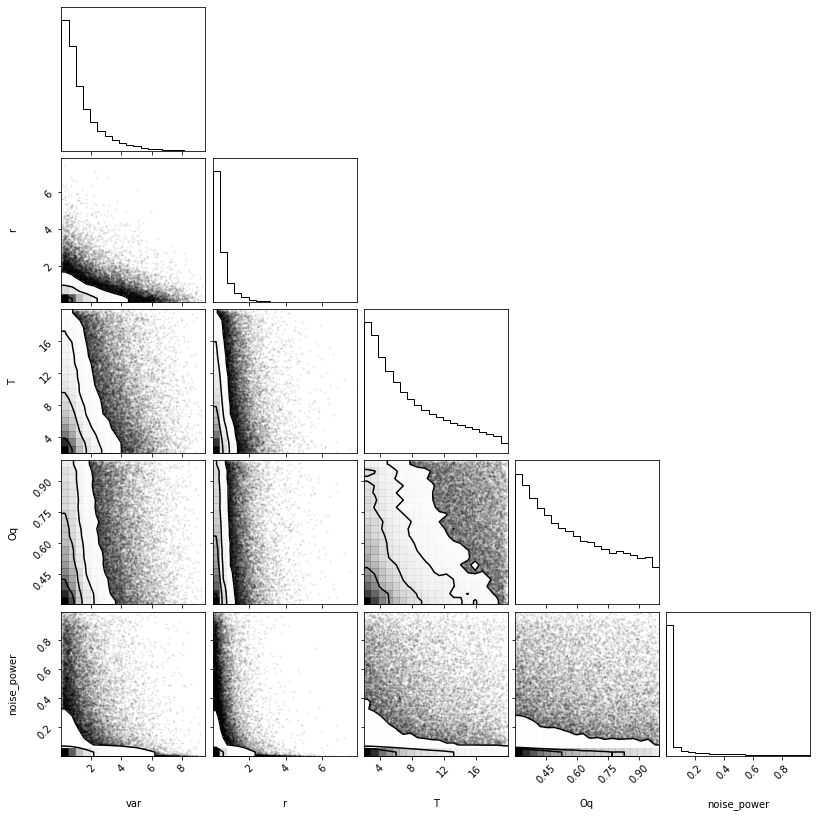

In [17]:
test_samples = prior.sample(100000, seed=jax.random.PRNGKey(54544))

import corner
corner.corner(np.array(test_samples), labels=['var', 'r', 'T', 'Oq', 'noise_power'])

pack(test_samples)

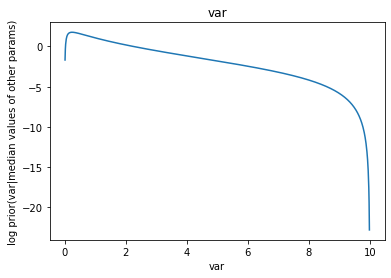

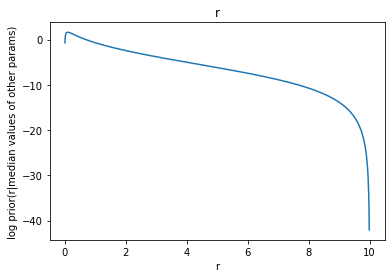

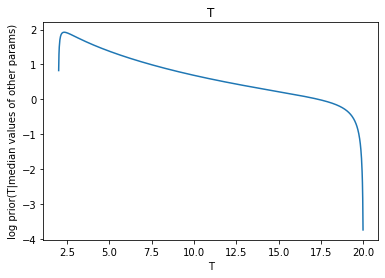

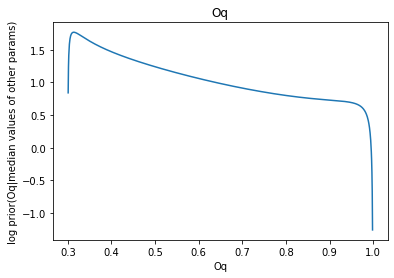

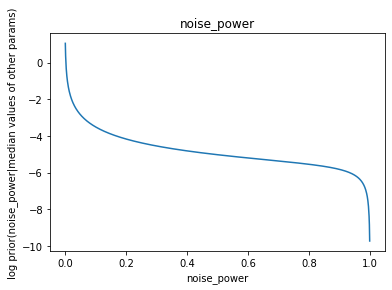

In [18]:
# We have annoying behavior of the density functions
# near the boundaries (and nans if you get too close)
# There *is* mass at the boundaries, as can be seen from
# samples, but not overwhelmingly so
MEDIANS = constants.SOURCE_MEDIAN.copy()
MEDIANS['noise_power'] = constants.db_to_power(-30.)

def probe_param_bounds(param, n=1000):
    lower, upper = BOUNDS[param]
    values = jnp.linspace(lower, upper, n)

    a = unpack(MEDIANS)
    a = np.repeat(a[None,:], n, axis=0)
    theta_test = pack(a)
    theta_test[param] = values
    a = unpack(theta_test)
    
    return values, prior.log_prob(a)

def test_param_bounds(param, n=1000):
    values, lp = probe_param_bounds(param, n=n)
    plot(values, lp)
    title(param)
    ylabel(f'log prior({param}|median values of other params)')
    xlabel(param)
    show()

test_param_bounds('var')
test_param_bounds('r')
test_param_bounds('T')
test_param_bounds('Oq')
test_param_bounds('noise_power')

In [19]:
from jax.scipy.stats import norm
from jax.experimental.host_callback import call

def minus_inf_if_nan(x):
    return jax.lax.cond(jnp.isnan(x), lambda: -jnp.inf, lambda: x)

def calculate_prior(packed_z): # Standardnormal
    z = unpack(packed_z)
    return jnp.sum(norm.logpdf(z))

def calculate_likelihood(theta, sample, config):
    R = core.kernelmatrix_root_gfd_oq(
        config['kernel'],
        theta['var'],
        theta['r'],
        sample['t'],
        config['kernel_M'],
        theta['T'],
        theta['Oq'],
        config['c'],
        config['impose_null_integral']
    )
    logl = core.loglikelihood_hilbert(R, sample['u'], theta['noise_power'])
    return logl

def calculate_pseudo_likelihood(packed_z, sample, config):
    """
    We perform a hack here and enforce the impact of the log det jacobian **of the prior**
    by summing it with the likelihood. This is correct as log prior and log likelihood
    are being summed to calculate the log posterior. But it smells a bit because
    technically the log volume correction should only be applied to the prior, as the
    likelihood is not a density with respect to the parameters, only to the data.
    """
    z = unpack(packed_z)
    
    # Calculate the actual likelihood L(theta) = p(sample|theta)
    theta = pack(bijector.forward(z))
    log_like = calculate_likelihood(theta, sample, config).squeeze()
    
    # Doesn't work with gradients
    #def printdebug(theta):
        #print({k: float(v) for k, v in theta.items()})

    #call(printdebug, theta)
    
    # Calculate the log volume factors of the transforms `z -> theta`
    # Note the minus sign here!! This is the correct way.
    prior_log_det_jac = -bijector.forward_log_det_jacobian(z).squeeze()
    
    return minus_inf_if_nan(log_like + prior_log_det_jac)

In [20]:
lf_samples = source.get_lf_samples()

z = randn(5)
packed_z = pack(z)
theta = pack(bijector.forward(z))

sample = lf_samples[1]

config = dict(
    kernel_name = 'Matern32Kernel',
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

assert config['use_oq'] == True
config['kernel'] = isokernels.resolve(config['kernel_name'])
config['c'] = constants.BOUNDARY_FACTOR

calculate_prior(packed_z), calculate_pseudo_likelihood(packed_z, sample, config)

[Memory]935.2s, 15.6min : Loading get_lf_samples...


(DeviceArray(-6.71229148, dtype=float64),
 DeviceArray(85.57245475, dtype=float64))

In [21]:
from functools import partial

log_prior_func = jax.jit(calculate_prior)
log_like_func = jax.jit(partial(calculate_pseudo_likelihood, sample=sample, config=config))

packed_z = pack(randn(5))

display(jax.value_and_grad(log_prior_func)(packed_z))
display(jax.value_and_grad(log_like_func)(packed_z))

(DeviceArray(-6.0269658, dtype=float64),
 {'Oq': DeviceArray(0.2246378, dtype=float64),
  'T': DeviceArray(-0.37843136, dtype=float64),
  'noise_power': DeviceArray(-0.2993453, dtype=float64),
  'r': DeviceArray(-0.13444255, dtype=float64),
  'var': DeviceArray(1.60099701, dtype=float64)})

(DeviceArray(151.90212026, dtype=float64),
 {'Oq': DeviceArray(34.99489665, dtype=float64),
  'T': DeviceArray(-51.58991826, dtype=float64),
  'noise_power': DeviceArray(-202.43297006, dtype=float64),
  'r': DeviceArray(7.09753069, dtype=float64),
  'var': DeviceArray(-1.068664, dtype=float64)})

In [57]:
# We get infs in the objective function and nans in the gradients
# when one of the `M` samples happens to hit a bound of the
# `bijector`. If it
# happens, all evaluations return infs and nans. So the problems
# are due to the problematic behavior of the log det jac of
# the prior transformation from N(0,I) to the actual model
# parameters at the bounds
# But our log likelihood is well behaved!!
#
# How to fix??
# Either put `M = 3` very low or (and we did it here)
# rescale the covariance `cov_z` to be much smaller such that
# the bounds never get reached.
import jax_advi.advi

theta_shapes = {
    'var': (),
    'r': (),
    'T': (),
    'Oq': (),
    'noise_power': ()
}

result = jax_advi.advi.optimize_advi_mean_field(
    theta_shapes,
    log_prior_func,
    log_like_func,
    verbose=True,
    M=50,
    #var_param_inits={'mean': (0.,1.), 'log_sd': (0.,1.)},
    opt_method="L-BFGS-B" # This is faster and seems to be leap succesfully over early local minima
)

37428.52776426401 300981.3800780381
8472.85314932361 49344.01449961321
2933.8556501643657 15881.8475294169
1592.9744818806432 10747.136856042072
246.5349531405241 2450.1174756062164
110.30026250676501 1468.0765514603654
3.4677123476178595 620.6724983502495
-30.941448095328933 295.1209004472352
-46.32053395954422 139.01339744044864
-54.47839429993333 81.30188968513858
-63.416149278213766 88.6512952530573
-95.95962779629848 95.84822860284187
253.7366740067449 2684.0809470526447
-107.7941396674775 28.31328067228583
-109.13490206088007 60.63099556115563
-111.6936298081321 69.68261298373024
-140.4647906829445 81.94249228197876
-34.42171481291412 793.0485350078452
-140.60370971026526 77.93685184200488
-142.1735900765072 50.311390377853314
-154.65300944941598 70.70065261351459
-168.22640844365844 111.37241038407038
-197.60865844028362 159.74624346178132
-233.34684405002022 159.95048957808086
-255.32722183662224 92.84773686081988
-305.13824230072305 71.75432656473718
23311.36135708464 55592.46

In [58]:
pack(bijector.forward(unpack(result['free_means'])))

{'var': DeviceArray([0.10900245], dtype=float64),
 'r': DeviceArray([0.38111461], dtype=float64),
 'T': DeviceArray([10.08205082], dtype=float64),
 'Oq': DeviceArray([0.67664196], dtype=float64),
 'noise_power': DeviceArray([2.82352771e-06], dtype=float64)}

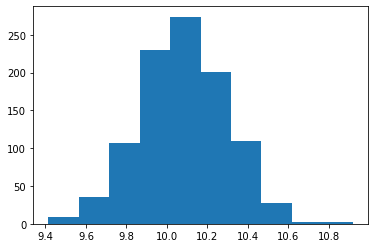

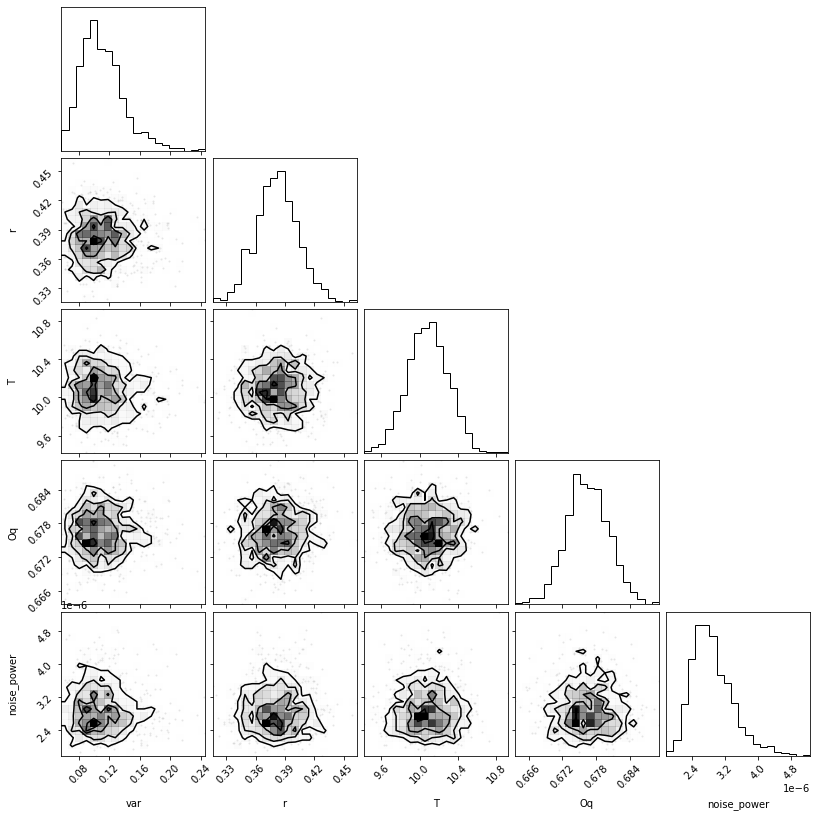

In [59]:
posterior = pack(bijector.forward(unpack(result['draws'])))

hist(np.array(posterior['T']))

corner.corner(np.array(unpack(posterior)), labels=PARAMS, 
              #range=[BOUNDS[k] for k in PARAMS]
             );

The open quotient `Oq` of the LF model correlates only moderately with the OQ as we see it. Namely we see the OQ as a "hard" close where the DGF waveform is zero. The LF model has an exponential return phase and a "soft" close such that the `Oq` is quite fuzzily defined. So we cannot expect our inferred `Oq` to correspond with the `Oq` of LF, because of this soft return phase. Our implementation of `Oq` is just dividing the pitch period into a hard zero (closed) phase and a nonzero (open) phase.

In [60]:
sample

{'p': {'T0': array(10.05578738),
  'Oq': array(0.3865609),
  'am': array(0.77388541),
  'Qa': array(0.09942556),
  'Te': array(3.88717424),
  'Tp': array(3.00822741),
  'Ta': array(0.61331782)},
 't': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
         5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
         6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
         7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
         8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
         9.9, 10. , 10.1]),
 'u': array([-3.10318264e-04, -1.96834372e-03, -2.50477017e-03, -1.02352002e-03,
        -1.79414120e-03, 

In [61]:
## Try better errorbars from <https://github.com/martiningram/jax_advi/blob/main/examples/Tennis%20example.ipynb>

from jax_advi.lrvb import compute_lrvb_covariance, get_posterior_draws_lrvb

lrvb_free_sds, lrvb_cov_mat = compute_lrvb_covariance(
    result['final_var_params_flat'], result['objective_fun'], result['shape_summary'], batch_size=8)

100%|█████████████████████████████████████████████| 1/1 [01:09<00:00, 69.00s/it]


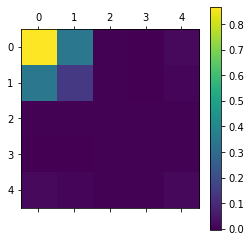

In [62]:
matshow(lrvb_cov_mat); colorbar();

In [64]:
lrvb_free_sds # GOOD: These are several times larger than the vanilla free_sds

{'var': DeviceArray(0.93171651, dtype=float64),
 'r': DeviceArray(0.37293228, dtype=float64),
 'T': DeviceArray(nan, dtype=float64),
 'Oq': DeviceArray(0.04595256, dtype=float64),
 'noise_power': DeviceArray(0.11754008, dtype=float64)}

In [66]:
result['free_sds']

{'var': DeviceArray(0.21740364, dtype=float64),
 'r': DeviceArray(0.05457795, dtype=float64),
 'T': DeviceArray(0.02754232, dtype=float64),
 'Oq': DeviceArray(0.01288414, dtype=float64),
 'noise_power': DeviceArray(0.08977138, dtype=float64)}